# Granite-TimeSeries-TTM   

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

In [102]:
import os
from typing import List, Optional
import pathlib

import numpy as np
import pandas as pd
from transformers import EarlyStoppingCallback, set_seed, Trainer, TrainingArguments
import matplotlib.pyplot as plt

from tsfm_public import TinyTimeMixerForPrediction, TimeSeriesPreprocessor, TimeSeriesForecastingPipeline
from tsfm_public.toolkit.time_series_preprocessor import (
    prepare_data_splits,
    get_datasets,
    create_timestamps
)
from tsfm_public.toolkit import ForecastDFDataset

set_seed(42)

In [2]:
import tsfm_public
tsfm_public.__version__

'0.2.8.dev6+gcb3982e'

## Initial setup
1. Download energy_data.csv.zip and weather_data.csv.zip from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
2. Place the downloaded files into a folder and update the data_path below

data_path = pathlib.Path("./data")

In [54]:
def compute_metric(actual, prediction):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    mask = ~np.any(np.isnan(a), axis=1)  # ~np.isnan(a)
    p = np.asarray(prediction.tolist())
    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    return dict(mean_squared_error=mse, root_mean_squared_error=np.sqrt(mse))
               

def plot_predictions(
    ground_truth_df: pd.DataFrame,
    predictions: pd.DataFrame,
    freq: str,
    timestamp_column: str,
    id_columns: Optional[List[str]] = None,
    plot_dir: str = None,
    num_plots: int = 10,
    plot_prefix: str = "valid",
    channel: str = None,
    truncate_history: bool = True,
):
    """Utility for plotting forecasts along with history.

    Args:
        model (torch.nn.Module): A trained model.
        dset (torch.utils.data.Dataset): Dataset that was fed into Trainer for predicting
        plot_dir (str, optional): A location to save the plot. If None, no plot is saved. Defaults to None.
        num_plots (int, optional): Number of sub-plots (context windows) to include. Defaults to 10.
        plot_prefix (str, optional): A prefix for the saved filename. Defaults to "valid".
        channel (int, optional): Which channels to plot for a multivariate dataset. Defaults to -1.
        truncate_history (bool, optional): If True only some hisotry (2 * pred_len samples) will be included in the plot. Defaults to True.
    """
    # device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu")
    # device = model.device
    random_indices = np.random.choice(len(predictions), size=num_plots, replace=False)
    # ground_truth_subset = [ground_truth.iloc[i].values for i in random_indices]
    predictions_subset = [predictions.iloc[i] for i in random_indices]

    #y_hat = output.prediction_outputs[:, :, channel].detach().cpu().numpy()

    pred_len = len(predictions_subset[0][channel])

    # Set a more beautiful style
    plt.style.use("seaborn-v0_8-whitegrid")

    # Adjust figure size and subplot spacing
    assert num_plots >= 1
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots))
    if num_plots == 1:
        axs = [axs]

    for i, ri in enumerate(random_indices):
        ts = create_timestamps(predictions_subset[i][timestamp_column], freq=freq, periods=pred_len)
        y_hat = predictions_subset[i][f"{channel}_prediction"]
        y = predictions_subset[i][f"{channel}"]

        # y = batch["future_values"][:pred_len, channel].squeeze().cpu().numpy()
        # if truncate_history:
        #     x = batch["past_values"][-2 * pred_len :, channel].squeeze().cpu().numpy()
        # else:
        #     x = batch["past_values"][:, channel].squeeze().cpu().numpy()
        # y = np.concatenate((x, y), axis=0)

        # Plot predicted values with a dashed line
        # y_hat_plot = np.concatenate((x, y_hat[i, ...]), axis=0)
        axs[i].plot(ts, y_hat, label="Predicted", linestyle="--", color="orange", linewidth=2)

        # Plot true values with a solid line
        axs[i].plot(ts, y, label="True", linestyle="-", color="blue", linewidth=2)

        # Plot horizon border
        # axs[i].axvline(x=2 * pred_len, color="r", linestyle="-")

        axs[i].set_title(f"Example {random_indices[i]}")
        axs[i].legend()

    # Adjust overall layout
    plt.tight_layout()

    # Save the plot
    if plot_dir is not None:
        plot_filename = f"{plot_prefix}_ch_{str(channel)}.pdf"
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, plot_filename))




## Load and prepare data

In [89]:
# Download energy_data.csv.zip from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

dataset_path = data_path / "energy_dataset.csv.zip"
timestamp_column = "time"

id_columns = []
control_columns = []

# control_columns = [
#     "temp",
#     "temp_min",
#     "temp_max",
#     "pressure",
#     "wind_speed",
#     "wind_deg",
#     "humidity",
#     "rain_1h",
#     "rain_3h",
#     "clouds_all",
# ]

target_columns = ["total load actual"]

context_length = 512
prediction_length = 96

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

data[timestamp_column] = pd.to_datetime(data[timestamp_column], utc=True)
data = data.ffill() # data.mean())

data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


## Create a TimeSeriesPreprocessor and prepare datasets

In [94]:
split_params = {"train": [0, 0.6], "valid": [0.6, 0.8], "test": [0.8, 1.0]}

params = dict(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=target_columns,
    control_columns=control_columns,
    context_length=512,
    prediction_length=96,
)

tsp = TimeSeriesPreprocessor(
    **params,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_data, valid_data, test_data = prepare_data_splits(
    data,
    id_columns=params["id_columns"],
    context_length=params["context_length"],
    split_config=split_params,
)

dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config=split_params)


## Load pretrained Granite-TimeSeries-TTM model (zero-shot)
The **TTM** model supports huggingface model interface, allowing easy API for loading the saved models.

In [6]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1",
    num_input_channels=tsp.num_input_channels,
    prediction_channel_indices=tsp.prediction_channel_indices,
)
model_parameters = sum(
    p.numel() for p in zeroshot_model.parameters() if p.requires_grad
)
print("TTM Model parameters:", model_parameters)

TTM Model parameters: 805280


### Create a time series forecasting pipeline and evaluate performance

In [7]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=target_columns,
    control_columns=control_columns,
    batch_size=2000,
    feature_extractor=tsp,
)
zeroshot_forecast = pipeline(tsp.preprocess(test_data), inverse_scale_outputs=True)
zeroshot_forecast.head()

,time,total load actual_prediction,total load actual
0,2018-03-14 17:00:00,"[34301.32638747344, 34410.1279593795, 33894.03...","[35043.99973664599, 36229.999787301436, 35065...."
1,2018-03-14 18:00:00,"[35315.78704947306, 34552.1894837591, 32776.58...","[36229.999787301436, 35065.000150100284, 32327..."
2,2018-03-14 19:00:00,"[35010.7386956451, 32997.36807303803, 30518.40...","[35065.000150100284, 32327.999963904855, 29527..."
3,2018-03-14 20:00:00,"[32900.67038074348, 30506.35288397865, 28315.7...","[32327.999963904855, 29527.999966038646, 27513..."
4,2018-03-14 21:00:00,"[29735.098753113165, 27862.558666544886, 26264...","[29527.999966038646, 27513.00002212207, 25726...."


In [26]:
compute_metric(zeroshot_forecast["total load actual"], zeroshot_forecast["total load actual_prediction"])

{'mean_squared_error': 8539918.318836246,
 'root_mean_squared_error': 2922.313863847661}

time                                                          2018-07-17 13:00:00
total load actual_prediction    [34208.30356343453, 33752.037537616714, 33459....
total load actual               [35369.00025211243, 35213.00013531181, 34627.9...
Name: 2996, dtype: object
<class 'pandas.core.series.Series'>
pred_len 96
time                                                          2018-09-21 23:00:00
total load actual_prediction    [24500.837544122503, 24072.183646742596, 23987...
total load actual               [24596.999953104038, 24067.99989196164, 23591....
Name: 4590, dtype: object
<class 'pandas.core.series.Series'>
pred_len 96


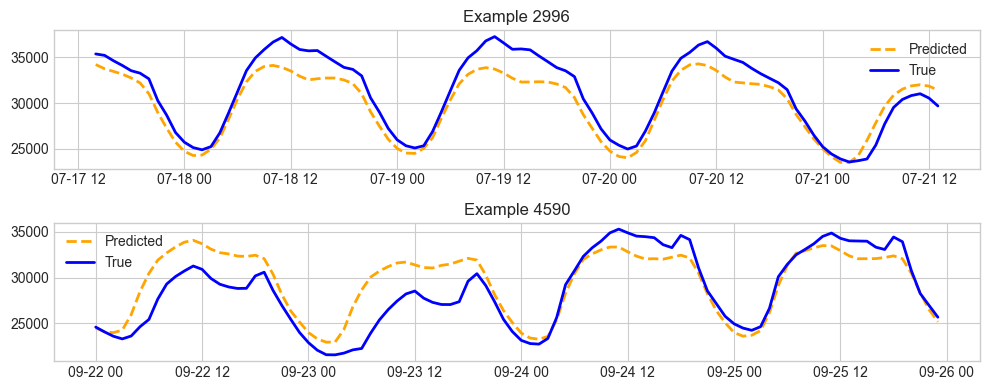

In [103]:
plot_predictions(test_data,
    zeroshot_forecast,
    timestamp_column=timestamp_column,
    freq=tsp.freq,
    plot_dir = None,
    num_plots = 2,
    plot_prefix = "Test",
    channel = "total load actual",
    truncate_history = True,
)

In [27]:
set_seed(42)
finetune_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1",
    num_input_channels=tsp.num_input_channels,
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_use_mixer=True,
    fcm_context_length=10,
    enable_forecast_channel_mixing=True,
    decoder_mode="mix_channel",
)

# freeze parameters in the model backbone
for param in finetune_model.backbone.parameters():
    param.requires_grad = False

finetune_model_parameters = sum(
    p.numel() for p in finetune_model.parameters() if p.requires_grad
)
print("TTM Model parameters:", finetune_model_parameters)

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: pytorch
Initializing Linear layers with method: 

## Useful links

TinyTimeMixer paper: https://arxiv.org/abs/2401.03955  

Granite-TimeSeries-TTM model: https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1  

Publicly available tools for working with our models: https://github.com/ibm-granite/granite-tsfm

© 2024 IBM Corporation